In [1]:
import igraph as ig
import numpy as np
import os
import pandas as pd
import random
from time import time
import math
import powerlaw
import matplotlib.pyplot as plt
import networkx as nx
import nx_cugraph as nxcg
from auxiliar_bb import noise_corrected, disparity
from auxiliar_projections_large import apply_projection

In [2]:
FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
PROJ_NAME = ["simple", "weights", "master", "hyper", "resall"]

In [3]:
###### ****** Read BI GRAPH ****** ######
g = ig.read(FILENAME)
print(g.summary())
print()

user_nodes = g.vs.select(type=0)
res_nodes = g.vs.select(type=1)

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()
print("|U|=",len(user_nodes), " \t|R|=",len(res_nodes), " \t|U|+|R|=",
      len(user_nodes)+len(res_nodes), "=", g.vcount())
print()
###### ****** END ****** ######

IGRAPH UN-T 511463 1470404 -- 
+ attr: id (v), name (v), type (v)

The graph IS bipartite
|U|= 383640  	|R|= 127823  	|U|+|R|= 511463 = 511463



In [15]:
def escalar_pesos(grafo, remove_zeros=False):
    """Función para escalar los pesos."""
    ### Se eliminan las aristas igual a 0
    if remove_zeros:
        edges_to_remove = grafo.es.select(weight_eq=0.0)
        idx_edges_to_remove = []
        for edge_ in edges_to_remove:
            idx_edges_to_remove.append(edge_.index)
        grafo.delete_edges(idx_edges_to_remove)
        print(f"Aristas con peso 0 = {len(idx_edges_to_remove)} eliminadas")


    ### Factor de Escalado
    edges_temp = grafo.es["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Determinar si el peso minimo es 0
    if min(edges_temp) == 0.0:
        # Se obtiene el minimu segundo
        min_val = sorted(set(grafo.es["weight"]))[1]
        factor_escala = math.ceil(1 / min_val)
        print("Factor de escala:", factor_escala)

    else:
        factor_escala = math.ceil(1 / min(edges_temp))
        print("Factor de escala:", factor_escala)
    
    grafo.es["weight"] = (np.array(edges_temp) * factor_escala).round().astype(int)

    if not remove_zeros:
        for edge in grafo.es:
            if edge["weight"] == 0:
                edge["weight"] = 1
    
    return grafo

def apply_backboning(graph, dataset, proj_opcion, nodetype, remove_zeros):
    g_toy = graph.copy() # Graph to analyze
    print("\n##### **** BACKBONING USERS **** #####")
    print("Projection Name:", proj_opcion)
    print("Summary\n",g_toy.summary())
    print("##### END #####")
    print()

    g_toy = escalar_pesos(g_toy, remove_zeros)
    print(f"Peso máximo={max(g_toy.es['weight'])} y mínimo={min(g_toy.es['weight'])} en aristas: ")
    print()

    ### Disparity filter ###
    a = time()
    bb_df = disparity(g_toy)
    b = time() - a
    print("TOP DF - time: %.10f seconds." % b)
    for alpha__, g__ in bb_df.items():
        print(f"Grafo filtrado con alpha={alpha__}: {g__.summary()}")        
        if nodetype == 0:
            flname = (
                dataset+"/top/"+dataset+"_top_" + proj_opcion + "_DF_a" + str(alpha__)[2:] + ".graphml"
            )
        else:
            flname = (
                dataset+"/bot/"+dataset+"_bot_" + proj_opcion + "_DF_a" + str(alpha__)[2:] + ".graphml"
            )
        g__.write_graphml(flname)
    print("================================")



    ### Noise Corrected ###
    a = time()
    bb_nc = noise_corrected(g_toy)
    b = time() - a
    print("TOP NC - time: %.10f seconds." % b)
    for alpha__, g__ in bb_nc.items():
        print(f"Grafo filtrado con alpha={alpha__}: {g__.summary()}")
        if nodetype == 0:
            flname = (
                dataset+"/top/"+dataset+"_top_" + proj_opcion + "_NC_a" + str(alpha__)[2:] + ".graphml"
            )
        else:
            flname = (
                dataset+"/bot/"+dataset+"_bot_" + proj_opcion + "_NC_a" + str(alpha__)[2:] + ".graphml"
            )
        g__.write_graphml(flname)
    print("================================")
    print()
    print("##### ***** Done BACKBONIN GUSERS ***** #####")
    ###### ****** END ****** ######

In [16]:
for proj_opcion in PROJ_NAME:
    ###### ****** Projections ****** ######
    user_graph = apply_projection(g, proj_opcion,
                                len(user_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = user_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    rsrs_graph = apply_projection(g, proj_opcion,
                                len(user_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = rsrs_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([user_graph, rsrs_graph]):
        apply_backboning(graph_type, dataset="am", proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=216 y mínimo=1 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=69 y mínimo=1 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: simple
Summary
 IGRAPH UNWT 383640 15038083 -- 
+ attr: id (v), name (v), type (v), weight (e)
##### END #####

Peso máximo=216 y mínimo=1 en aristas: 

Factor de escala: 1
Peso máximo=216 y mínimo=1 en aristas: 

TOP DF - time: 5.4016399384 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 380191 85601 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH UNWT 383032 207378 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH UNWT 383481 404348 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH UNWT 383481 754540 -- 
+ attr: id (v), name (v), type (v), weight (e)
TOP NC - time: 13.4715371132 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 383640 14963570 -- 
+ attr: id (v), n

KeyError: 'Attribute does not exist'

In [6]:
def bipartite_cc_uu_prime(graph, u_id, u_prime_id):
    """
    Calculates the Jaccard index based clustering coefficient for a pair of vertices
    u and u' from the same set of nodes in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        u_id: The ID of the first vertex.
        u_prime_id: The ID of the second vertex.

    Returns:
        The Jaccard index (cc_u_u_prime) or 0 if union of neighbors is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")

    # Get neighbors of u and u'
    neighbors_u = set(graph.neighbors(u_id))
    neighbors_u_prime = set(graph.neighbors(u_prime_id))

    # Calculate intersection and union
    intersection = len(neighbors_u.intersection(neighbors_u_prime))
    union = len(neighbors_u.union(neighbors_u_prime))

    if union == 0:
        return 0.0
    return intersection / union
 
def local_bipartite_clustering_coefficient(graph, u_id, U_type_value=False):
    """
    Calculates the local clustering coefficient for a vertex u in a bipartite graph.
    The formula uses neighbors of neighbors (N(N(u))) that are of the same type as u.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute
               (e.g., True/False or 0/1 for the two partitions).
        u_id: The ID of the vertex for which to calculate the local clustering coefficient.
        U_type_value: The boolean value (True/False) that indicates the partition
                      to which node u belongs. All nodes in U should have this type.

    Returns:
        The local clustering coefficient for vertex u, or 0 if N(N(u)) is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Ensure u_id is of the specified U_type_value
    if graph.vs[u_id]["type"] != U_type_value:
        raise ValueError(f"Vertex {u_id} does not belong to the specified partition U.")

    # Get neighbors of u
    neighbors_u = graph.neighbors(u_id)
    
    # Get neighbors of neighbors of u, filtering for nodes of the same type as u
    # These are the u' nodes in N(N(u)) that are in the same partition U
    nn_u = set()
    for v_neighbor_id in neighbors_u:
        for nn_id in graph.neighbors(v_neighbor_id):
            if graph.vs[nn_id]["type"] == U_type_value and nn_id != u_id: # Exclude u itself
                nn_u.add(nn_id)

    if not nn_u:
        return 0.0

    sum_cc_uu_prime = 0.0
    for u_prime_id in nn_u:
        sum_cc_uu_prime += bipartite_cc_uu_prime(graph, u_id, u_prime_id)

    return sum_cc_uu_prime / len(nn_u)

def average_local_bipartite_clustering_coefficient(graph, U_type_value=False):
    """
    Calculates the average local clustering coefficient for a set of nodes U
    in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        U_type_value: The boolean value (True/False) that indicates the partition
                      for which to calculate the average clustering coefficient.

    Returns:
        The average local clustering coefficient for the set U.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Get all vertices in set U
    U_vertices_ids = [v.index for v in graph.vs if v["type"] == U_type_value]

    if not U_vertices_ids:
        return 0.0

    sum_cc_u = 0.0
    for u_id in U_vertices_ids:
        sum_cc_u += local_bipartite_clustering_coefficient(graph, u_id, U_type_value)

    return sum_cc_u / len(U_vertices_ids)

def compute_power_law_bipartite(gb, type_n):
    """Calcula el alpha del bipartita"""
    fit = powerlaw.Fit(gb.degree(gb.vs.select(type=type_n)), discrete=True, verbose=False)
    return fit.alpha

def compute_power_law(g):
    """Calcula el alpha del proyectado"""
    fit = powerlaw.Fit(g.degree(), discrete=True, verbose=False)
    return fit.alpha

def remove_isolated_nodes(graph, k):
        
    #print(f"Número inicial de vértices: {graph.vcount()}")
    #print(f"Componentes iniciales: {len(graph.clusters())}")

    # 1. Obtener los clústeres
    clusters = graph.clusters()

    # 2. Identificar los IDs de los vértices a eliminar
    vertices_to_delete = []
    for i, cluster_members in enumerate(clusters):
        if len(cluster_members) < k:
            vertices_to_delete.extend(cluster_members)

    # Eliminar duplicados si un vértice pudiera aparecer en múltiples listas por algún error (no debería pasar con clusters)
    # Aunque igraph maneja esto bien, es una buena práctica si la lista se construye de forma menos controlada
    vertices_to_delete = sorted(list(set(vertices_to_delete)), reverse=True) # Eliminar en orden descendente para evitar problemas de reindexación

    # 3. Eliminar los vértices
    if vertices_to_delete:
        graph.delete_vertices(vertices_to_delete)
        #print(f"Nodos eliminados: {len(vertices_to_delete)}")

    #print(f"Número final de vértices: {graph.vcount()}")
    #print(f"Componentes finales: {len(graph.clusters())}")
    return graph

In [7]:
def compute_avg_path_length(g, k):
    G = g.to_networkx()
    nxG = nxcg.from_networkx(G)
    all_nodes = list(G.nodes())
    sample_nodes = random.sample(all_nodes, k)
    total_distances = 0
    reachable_pairs = 0
    for i, src_node in enumerate(sample_nodes):
        sssp_df = nxcg.shortest_path_length(nxG, source=src_node)
        total_distances += sum(sssp_df.values())
        reachable_pairs += len(sssp_df.values())

    apl_approx = float(total_distances) / reachable_pairs
    return apl_approx


def compute_bip_metrics(gb, typen):
    """Calcula x1,x2,x3,x8,x9,γ_Ub del grafo bipartito."""
    x1 = len(gb.vs.select(type=0))
    x2 = len(gb.vs.select(type=1))
    x3 = gb.ecount()
    #x8 = average_local_bipartite_clustering_coefficient(gb, U_type_value=typen)    
    x8 = 1
    x9 = compute_avg_path_length(gb, 100)
    x11 = compute_power_law_bipartite(gb, typen)
    return dict(x1=x1, x2=x2, x3=x3, x8=x8, x9=x9, x11=x11)

def compute_proj_metrics(gu, k):
    """Calcula x4,x5,x6,x7,x10,γ_U de la proyección."""
    x4 = gu.vcount()
    x5 = gu.ecount()
    x6 = len(gu.clusters(mode='weak'))
    x7 = gu.transitivity_undirected(mode="zero")
    x10 = compute_avg_path_length(gu, k)
    #try:
    #    x10 = gu.average_path_length(directed=False)
    #except:
    #    x10 = np.inf
    x12 = compute_power_law(gu)
    return dict(x4=x4, x5=x5, x6=x6, x7=x7, x10=x10, x12=x12)

def evaluate_solution(bip, proj, typen):
    """Dado bip y proj metrics, arma x, f, g."""
    # unimos diccionarios
    x = {
        **bip,
        **proj
    }
    # objetivos
    f = np.array([
        abs(x["x1"] - x["x4"]) if typen==0 else abs(x["x2"] - x["x4"]),
        (2*x["x5"]) / (x["x4"]*(x["x4"]-1)) if x["x4"]>1 else np.inf,
        x["x6"],
        1 - x["x7"],
        abs(x["x11"] - x["x12"]),
        abs(x["x9"] - x["x10"]),
    ])
    # restricciones g_i(x)<=0
    g = np.array([
        f[1] - x["x3"]/(x["x1"]*x["x2"]) if x["x1"]*x["x2"]>0 else np.inf,
    ])
    return dict(metrics=x, f=f, g=g, graph=proj)
    #return dict(metrics=x, f=f, graph=proj)

def is_feasible(sol):
    #return np.all(sol["g"] <= 0)
    if np.all(sol["g"] <= 0):
        return 1

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist

def pareto_rank_all(solutions):
    """
    Clasifica todas las soluciones en frentes de Pareto.
    Devuelve una lista de listas: cada sublista contiene un frente.
    """
    remaining = solutions.copy()
    fronts = []
    
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    
    return fronts



In [8]:
# —————————— Flujo principal ——————————
tnodes = 0

# 1) Leer el único grafo bipartito
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, tnodes)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 1,
 'x9': 7.2094347188771915,
 'x11': 1.8623650345000595}

In [9]:
# 2) Escanear carpeta de proyecciones
if tnodes == 0:
    proj_dir = "am/top"    
else:
    proj_dir = "am/bot" 
    
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]


# 3) Calcular soluciones
solutions = []
conta_neg = 0
to_df = []
names_df = []
k = 100
for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=5)
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    sol = evaluate_solution(bip_metrics, proj_metrics, tnodes)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname  # <- Añadimos esta línea
    solutions.append(sol)
    #if is_feasible(sol):
        #solutions.append(sol)
    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)
print("Soluciones factibles:", len(solutions))

Soluciones factibles: 80


In [41]:
to_save = pd.DataFrame(solutions)
if tnodes == 0:
    to_save.to_csv("datos_proj_top_act_mov.csv")
else:
    to_save.to_csv("datos_proj_bot_act_mov.csv")


In [10]:
all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol in front:
        print(f" - {sol['filename']} — f = {sol['f']}")



Frente 1 (42 soluciones):
 - am_top_jaccard_NC_a15.graphml — f = [4.74900000e+03 2.09397621e-04 5.17000000e+02 8.34121399e-01
 2.86253967e-01 3.42375929e+00]
 - am_top_simple_NC_a2.graphml — f = [4.74900000e+03 2.09398457e-04 5.17000000e+02 8.34866922e-01
 2.64521847e-01 3.48794456e+00]
 - am_top_hyper_DF_a1.graphml — f = [2.07484000e+05 4.05737401e-05 1.53500000e+04 2.65892133e-01
 2.24659372e+00 3.00383083e+00]
 - amz_top_master_NC_alpha1.graphml — f = [5.06800000e+03 1.93593600e-04 6.09000000e+02 8.55805929e-01
 1.72950433e-01 3.45082279e+00]
 - amz_top_resall_NC_alpha05.graphml — f = [4.74900000e+03 2.08999273e-04 5.17000000e+02 8.34763680e-01
 2.64806939e-01 3.48097676e+00]
 - am_top_hyper_NC_a2.graphml — f = [4.74900000e+03 2.09454685e-04 5.17000000e+02 8.33958802e-01
 2.64489193e-01 3.45424537e+00]
 - amz_top_simple_NC_alpha15.graphml — f = [4.74900000e+03 2.09323797e-04 5.17000000e+02 8.35757029e-01
 2.64565204e-01 3.36591883e+00]
 - amz_top_hyper_NC_alpha1.graphml — f = [4.74

In [11]:

cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))
print(pareto_sorted)

Crowding 42
[{'metrics': {'x1': 383640, 'x2': 127823, 'x3': 1470404, 'x8': 1, 'x9': 7.2094347188771915, 'x11': 1.8623650345000595, 'x4': 378891, 'x5': 15030353, 'x6': 517, 'x7': 0.16587860095777224, 'x10': 3.7856754274240276, 'x12': 2.1486190018609364}, 'f': array([4.74900000e+03, 2.09397621e-04, 5.17000000e+02, 8.34121399e-01,
       2.86253967e-01, 3.42375929e+00]), 'g': array([0.00017941]), 'graph': {'x4': 378891, 'x5': 15030353, 'x6': 517, 'x7': 0.16587860095777224, 'x10': 3.7856754274240276, 'x12': 2.1486190018609364}, 'filename': 'am_top_jaccard_NC_a15.graphml'}, {'metrics': {'x1': 383640, 'x2': 127823, 'x3': 1470404, 'x8': 1, 'x9': 7.2094347188771915, 'x11': 1.8623650345000595, 'x4': 176291, 'x5': 595803, 'x6': 15563, 'x7': 0.663512830287644, 'x10': 10.290886381463826, 'x12': 3.8972085580577156}, 'f': array([2.07349000e+05, 3.83420088e-05, 1.55630000e+04, 3.36487170e-01,
       2.03484352e+00, 3.08145166e+00]), 'g': array([8.35702716e-06]), 'graph': {'x4': 176291, 'x5': 595803, 

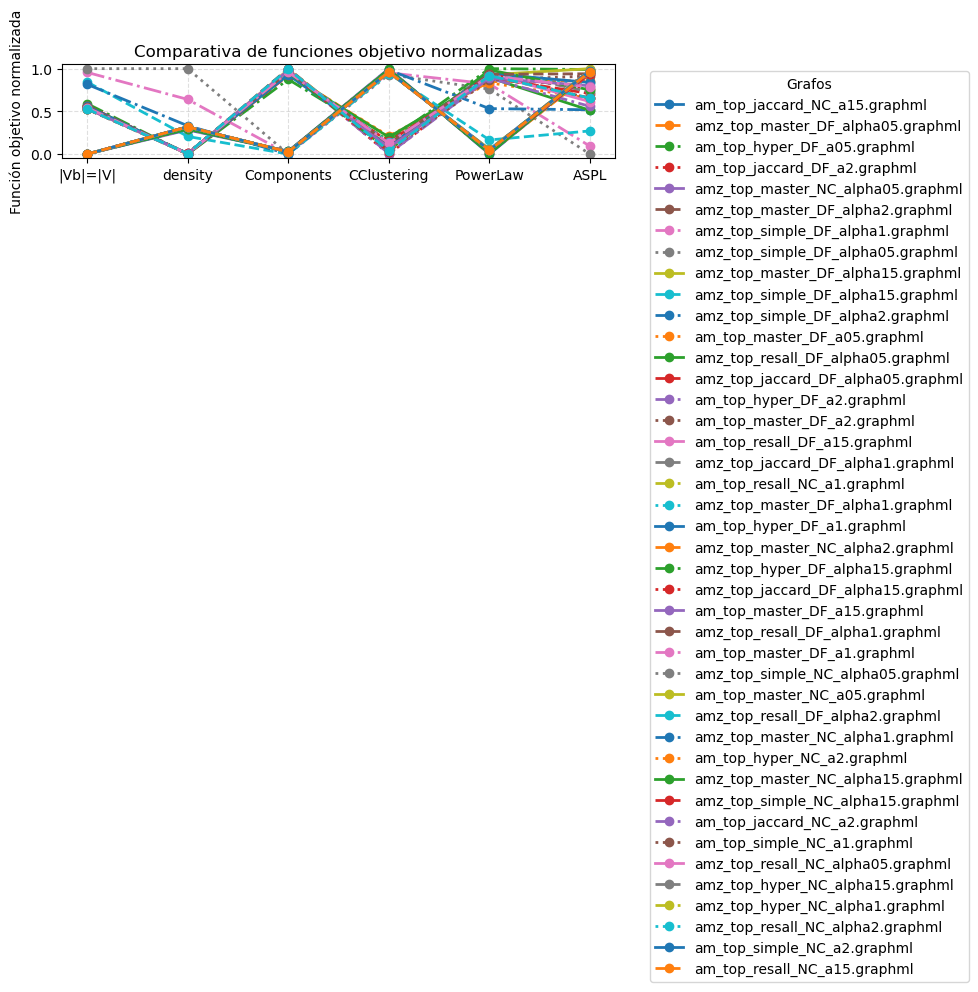

In [12]:
# Número máximo de grafos a graficar
N = len(pareto_sorted)
#labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6
labels = ["|Vb|=|V|", "density", "Components", "CClustering", "PowerLaw", "ASPL"]

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("test.png")
plt.show()
